In [57]:
## Importing libraries

import pandas as pd
import numpy as np
import sys
import os
import re
import emoji
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [58]:
# Read the data
df = pd.read_csv('../cleaned_tweet_data.csv')
print(df.shape)
df.head()

(8674, 15)


,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Apr 22 22:17:05 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",The 10-year yield is telling us that there's a...,0.16,0.540000,en,12179,43.0,davideiacovozzi,18,55,NaN,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",['axelmeyerko'],NaN
1,Fri Apr 22 13:44:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","German 10y mortgage rate went from 0,8% to 2,5...",0.15,0.175000,en,12179,32.0,davideiacovozzi,18,55,NaN,[],['JoanaCotar'],NaN
2,Fri Apr 22 06:10:34 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",When? https://t.co/kO2FfHKaZg,0.00,0.066667,en,12179,26.0,davideiacovozzi,18,55,False,[],['MichaelAArouet'],NaN
3,Thu Apr 21 17:22:09 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",The 30-year mortgage rate in the US rises to 5...,-0.40,0.400000,en,12179,213.0,davideiacovozzi,18,55,NaN,[],['goldseek'],NaN
4,Thu Apr 21 10:32:26 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",Rates rise until something breaks … is anythin...,-0.10,0.550000,en,12179,417.0,davideiacovozzi,18,55,False,[],['charliebilello'],NaN


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8674 entries, 0 to 8673
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          8674 non-null   object 
 1   source              8674 non-null   object 
 2   original_text       4314 non-null   object 
 3   polarity            8674 non-null   float64
 4   subjectivity        8674 non-null   float64
 5   lang                8674 non-null   object 
 6   favorite_count      8674 non-null   int64  
 7   retweet_count       4314 non-null   float64
 8   original_author     8674 non-null   object 
 9   followers_count     8674 non-null   int64  
 10  friends_count       8674 non-null   int64  
 11  possibly_sensitive  3393 non-null   object 
 12  hashtags            8674 non-null   object 
 13  user_mentions       8674 non-null   object 
 14  place               5590 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 1016.6

In [60]:
# Drop unaccessary columns
# df.drop(columns=['source','original_author','friends_count','user_mentions'], axis=1, inplace=True)
df = df[['original_text','polarity']]
print(df.shape)

(8674, 2)


In [61]:
# Check missing values
df.isna().sum()

original_text    4360
polarity            0
dtype: int64

In [62]:
# Drop rows with missing value
# Remove rows with null value of tweet text
df = df[~df['original_text'].isnull()]
df.shape

(4314, 2)

## Preprocessing
The preprocessing steps are:
* Remove rows with null text value
* Change data type to string
* Lower casing 
* Remove URLs: links starting with "http" or "https" or "www" are replaced by "URL"
* Replacing emois
* Replacing usernames
* Removing non-alphabets
* Removing consecutive letters: eg convert "Heyyyy" to "Heyy"
* Removing short words: words with length less than 2
* Removing stopwords
* Lemmatizing: converting a word to its base form

In [63]:

# Change the data type of tweet text to str
df['original_text'] = df['original_text'].astype(str)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(textdata):
    textdata = textdata.astype(str)
    processedText = []
    
    # Create Lemmatizer and Stemmer
    wordLemm = nltk.stem.WordNetLemmatizer()
    
    # Defining regex patters
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URLs with 'URL'
        tweet = re.sub(urlPattern, ' URL', tweet)
        
        # Replace all emojis
        tweet = emoji.demojize(tweet)
        
        # Replace @username to 'USER'
        tweet = re.sub(userPattern, ' USER', tweet)
        
        # Replace all non alphabets
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Replace 3 or more consecutive letters to 2 letter
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            # Replace if the word is a stopword
            if (word not in stop_words):
                if len(word) > 1:
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        
        processedText.append(tweetwords)
    
    return processedText

[nltk_data] Downloading package stopwords to /home/moges/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
# cleaned_data = preprocess(df['original_text']).head()
df['original_text'] = preprocess(df['original_text'])
df.head()

,original_text,polarity
0,10 year yield telling u high risk something br...,0.16
1,german 10y mortgage rate went 50 backhand inde...,0.15
2,URL,0.00
3,30 year mortgage rate u rise 11 highest level ...,-0.40
4,rate rise something break anything broken yet ...,-0.10


In [65]:
# Categorize the texts as positive, neutral and negative based on their polarity
def text_category(p):
    if p > 0:
        return 'positive'
    elif p == 0:
        return 'neutral'
    else:
        return 'negative'
    
df['score'] = df['polarity'].map(text_category)
df = df[df['score'] != 'neutral']
df.head()

,original_text,polarity,score
0,10 year yield telling u high risk something br...,0.16,positive
1,german 10y mortgage rate went 50 backhand inde...,0.15,positive
3,30 year mortgage rate u rise 11 highest level ...,-0.40,negative
4,rate rise something break anything broken yet ...,-0.10,negative
5,buying opportunity like occur every year bond ...,0.40,positive


In [66]:
df.groupby(['score']).count()

,original_text,polarity
score,,
negative,467,467
positive,1115,1115


<AxesSubplot:ylabel='original_text'>

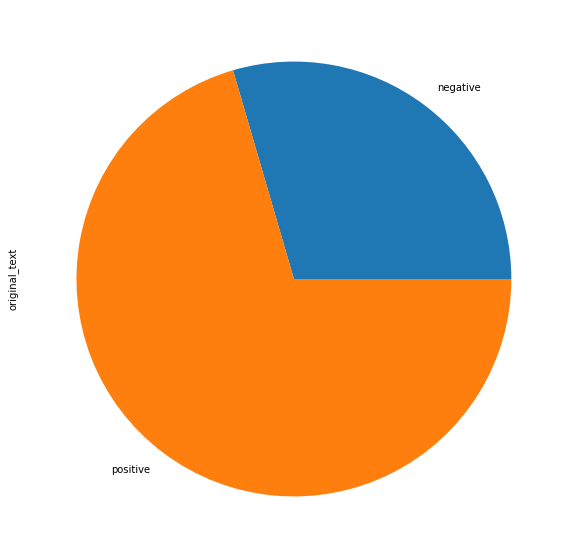

In [67]:
# visualize using PieChart
fig,axis=plt.subplots(figsize=(10,10))
df.groupby('score')['original_text'].count().plot.pie(ax=axis)

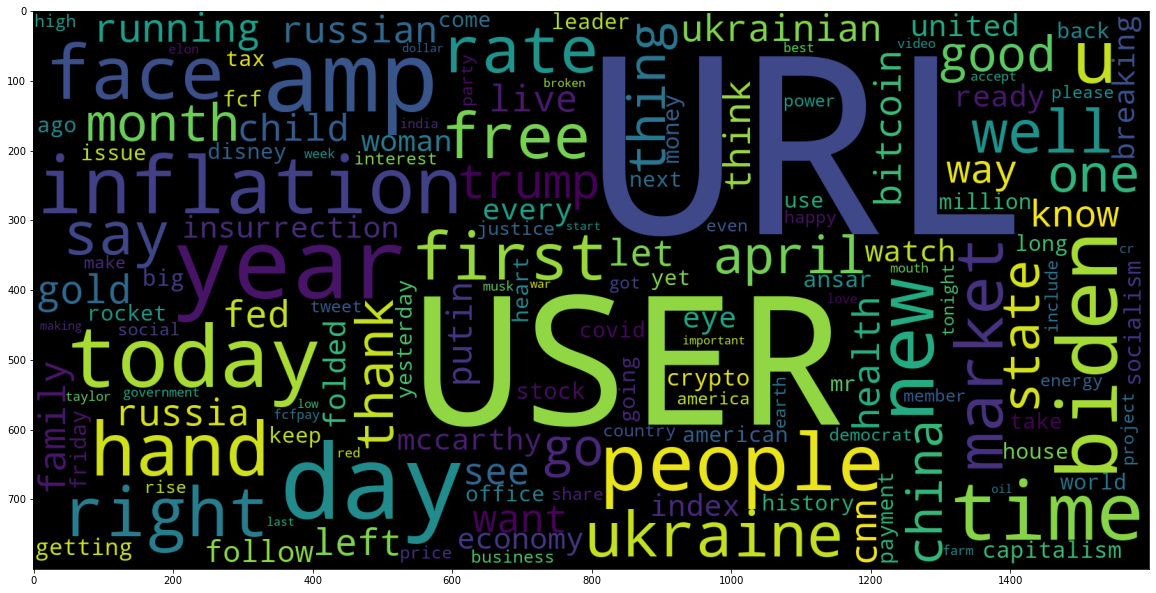

In [68]:
# Word-cloud for Negative tweets
data_neg = df[df['score'] == 'negative']['original_text']

plt.figure(figsize=(20,20))
wc = WordCloud(max_words=150, width=1600, height=800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

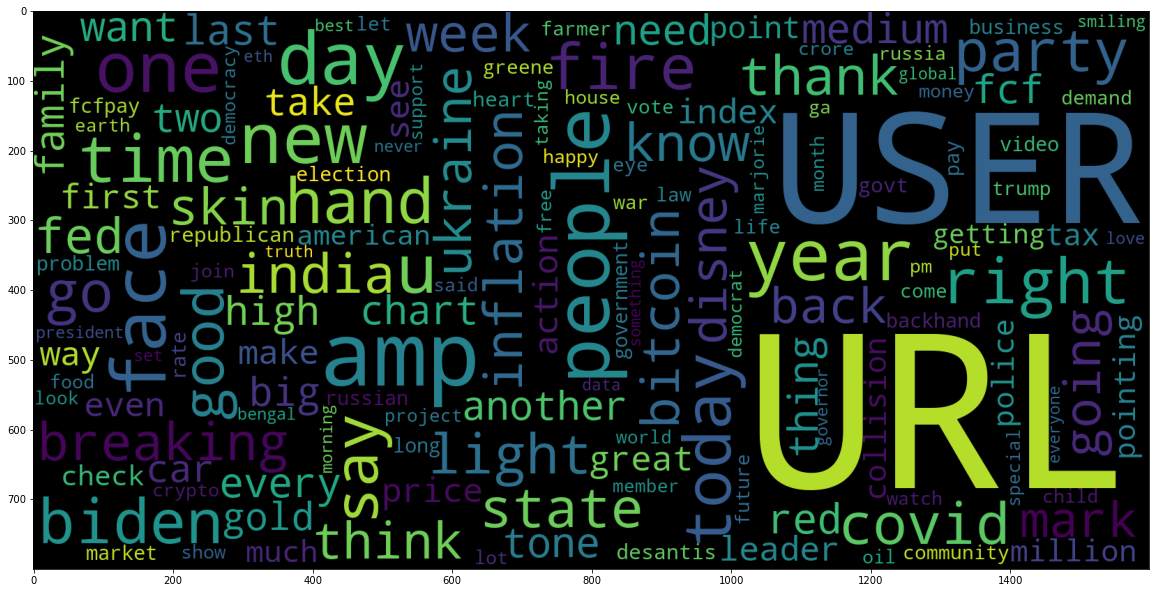

In [69]:
# Word-cloud for Positive tweets
data_pos = df[df['score'] == 'positive']['original_text']

plt.figure(figsize=(20,20))
wc = WordCloud(max_words=150, width=1600, height=800, collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

## Building Model

In [70]:
# Splitting the data
X = df['original_text']
Y = df['score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [71]:
# TF-IDF Vectoriser

vectoriser = TfidfVectorizer(ngram_range=(3,3))
vectoriser.fit(X_train)


TfidfVectorizer(ngram_range=(3, 3))

In [72]:
# Transforming the dataset
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [73]:
# Building model
LRmodel = LogisticRegression(C = 2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, Y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

In [74]:
# Predict using the model for test dataset
Y_pred = LRmodel.predict(X_test)
test_score = LRmodel.score(X_test, Y_test)
train_score = LRmodel.score(X_train, Y_train)
print('Test score: ' , round(test_score, 2))
print('Train score: ', round(train_score, 2))

Test score:  0.72
Train score:  0.95


In [75]:
# Splitting the data
X = df['original_text']
Y = df['score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [76]:
# TF-IDF Vectoriser

vectoriser = TfidfVectorizer(ngram_range=(3,3))
vectoriser.fit(X_train)

TfidfVectorizer(ngram_range=(3, 3))

In [77]:
# Transforming the dataset
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [78]:
# Building model
LRmodel = LogisticRegression(C = 2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, Y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

In [79]:
# Predict using the model for test dataset
Y_pred = LRmodel.predict(X_test)
test_score = LRmodel.score(X_test, Y_test)
train_score = LRmodel.score(X_train, Y_train)
print('Test score: ' , round(test_score, 2))
print('Train score: ', round(train_score, 2))

Test score:  0.72
Train score:  0.95
